In [45]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import os
import tempfile
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np



In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#Karpathy 1. fix random seed
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
ATT_FILE_NAME = "FootballPlayerPreparedCleanAttributes.csv"
ONE_HOT_ENCODED_CLASSES_FILE_NAME = "FootballPlayerOneHotEncodedClasses.csv"

In [5]:
att = pd.read_csv(ATT_FILE_NAME)
target = pd.read_csv(ONE_HOT_ENCODED_CLASSES_FILE_NAME)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
att.describe()

,Crossing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Stamina,LongShots,Aggression,Positioning,Vision,Composure
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,0.053537,0.064942,0.168294,-0.081373,0.122654,-0.030012,-0.132537,0.002751,0.076091,0.098800,0.125965,0.169170,-0.025506,0.136145,0.043417,0.060219,0.036497
std,0.344606,0.293820,0.268085,0.369549,0.301492,0.364944,0.358826,0.334822,0.282066,0.233806,0.326638,0.324097,0.379027,0.352347,0.349409,0.314939,0.274291
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.195122,-0.139241,0.013699,-0.375000,-0.012048,-0.325301,-0.428571,-0.189189,-0.070423,-0.066667,-0.086420,-0.014493,-0.301205,-0.097561,-0.166667,-0.146341,-0.162162
50%,0.097561,0.088608,0.205479,-0.075000,0.180723,-0.012048,-0.190476,0.054054,0.098592,0.093333,0.160494,0.188406,0.036145,0.170732,0.095238,0.097561,0.054054
75%,0.317073,0.265823,0.342466,0.200000,0.325301,0.253012,0.142857,0.243243,0.267606,0.253333,0.358025,0.391304,0.277108,0.390244,0.285714,0.292683,0.243243
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
target.head()

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [9]:
clases = np.argmax(target.to_numpy(),axis=1)

In [10]:
np.bincount(clases) # contar cuantos elemntos tengo de cada clase en el conjunto de datos

array([4296, 3868, 4353, 3605], dtype=int64)

In [11]:
c1, c2,c3,c4= np.bincount(clases)
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}") #lo mismo de arriba

Total: 16122. C1 4296, c2 3868, c3 4353, c4 3605


In [12]:
X_train,X_rem,y_train,y_rem = train_test_split(att,target,train_size=0.8)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,train_size=0.5)
#80 % train   --- 10% val 10% test

In [13]:
c1, c2,c3,c4= np.bincount(np.argmax(y_train.to_numpy(),axis=1))
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}")

Total: 12897. C1 3455, c2 3086, c3 3479, c4 2877


In [61]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

METRICS2 = [

      keras.metrics.CategoricalAccuracy(name='accuracy')


]


In [15]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [74]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [24]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


Observamos el overfit del modelo

In [ ]:
plt.plot(h_100x4x100.history['val_categorical_accuracy'])
plt.plot(h_100x4x100.history['categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy','train_accuracy'], loc='upper left')
plt.show()
# "Loss"

In [ ]:
plt.plot(h_128128.history['val_categorical_accuracy'])
plt.plot(h_nocapas.history['val_categorical_accuracy'])
plt.plot(h_512512.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['h28128', 'nocapas','512512'], loc='upper left')
plt.show()
# "Loss"


In [18]:
def build_model(n_hidden=1, n_neurons_ocultas=[30], input_shape=(8,), 
                activation_o="relu", optimizer="adam", loss="categorical_crossentropy", metrics=METRICS, 
                activation_s="soft_max", n_neurons_salida=4):     
    model = keras.models.Sequential()     
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    if n_hidden != len(n_neurons_ocultas):
        print("error, tamaño de la lista de n_neuronas no corresponde al numero de capas")
        return -1
    for layer in range(n_hidden):         
        model.add(keras.layers.Dense(n_neurons_ocultas[layer], activation="relu"))     
  
    model.add(keras.layers.Dense(n_neurons_salida, activation=activation_s))  
    model.compile(optimizer=optimizer,   
              loss=loss,
              metrics=metrics)    
    return model

In [160]:
  
first_decay_steps = 1000 
initial_learning_rate = 0.3
#lr_decayed_fn = (   tf.keras.optimizers.schedules.CosineDecayRestarts(       initial_learning_rate,       first_decay_steps))
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate) 
modelo = build_model(1, [100], (17,), "relu", optimizer, "categorical_crossentropy", METRICS, "softmax", 4)

BATCH_SIZE=64
EPOCHS=100

modelo.summary()
results_fit= modelo.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_test,y_test), batch_size=BATCH_SIZE)



Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 100)               1800      
                                                                 
 dense_122 (Dense)           (None, 4)                 404       
                                                                 
Total params: 2,204
Trainable params: 2,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
202/202 [==============================] - 2s 3ms/step - loss: 0.8889 - tp: 9681.0000 - fp: 3744.0000 - tn: 39786.0000 - fn: 4829.0000 - accuracy: 0.7033 - precision: 0.7211 - recall: 0.6672 - val_loss: 0.6345 - val_tp: 1155.0000 - val_fp: 401.0000 - val_tn: 4438.0000 - val_fn: 458.0000 - val_accuracy: 0.7365 - val_precision: 0.7423 - val_recall: 0.7161
Epoch 2/100
202/202 [==============================] - 0s 2ms/step - loss: 0.63

202/202 [==============================] - 0s 2ms/step - loss: 0.6307 - tp: 8964.0000 - fp: 3365.0000 - tn: 35326.0000 - fn: 3933.0000 - accuracy: 0.7158 - precision: 0.7271 - recall: 0.6950 - val_loss: 0.6001 - val_tp: 1175.0000 - val_fp: 402.0000 - val_tn: 4437.0000 - val_fn: 438.0000 - val_accuracy: 0.7433 - val_precision: 0.7451 - val_recall: 0.7285
Epoch 22/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6255 - tp: 8995.0000 - fp: 3308.0000 - tn: 35383.0000 - fn: 3902.0000 - accuracy: 0.7206 - precision: 0.7311 - recall: 0.6974 - val_loss: 0.7439 - val_tp: 1060.0000 - val_fp: 493.0000 - val_tn: 4346.0000 - val_fn: 553.0000 - val_accuracy: 0.6745 - val_precision: 0.6825 - val_recall: 0.6572
Epoch 23/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6365 - tp: 8938.0000 - fp: 3446.0000 - tn: 35245.0000 - fn: 3959.0000 - accuracy: 0.7135 - precision: 0.7217 - recall: 0.6930 - val_loss: 0.5803 - val_tp: 1031.0000 - val_fp: 278.0000 - val_tn: 456

202/202 [==============================] - 0s 2ms/step - loss: 0.6329 - tp: 9041.0000 - fp: 3312.0000 - tn: 35379.0000 - fn: 3856.0000 - accuracy: 0.7207 - precision: 0.7319 - recall: 0.7010 - val_loss: 0.5571 - val_tp: 1202.0000 - val_fp: 373.0000 - val_tn: 4466.0000 - val_fn: 411.0000 - val_accuracy: 0.7564 - val_precision: 0.7632 - val_recall: 0.7452
Epoch 44/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6355 - tp: 8910.0000 - fp: 3364.0000 - tn: 35327.0000 - fn: 3987.0000 - accuracy: 0.7136 - precision: 0.7259 - recall: 0.6909 - val_loss: 0.6176 - val_tp: 1169.0000 - val_fp: 426.0000 - val_tn: 4413.0000 - val_fn: 444.0000 - val_accuracy: 0.7322 - val_precision: 0.7329 - val_recall: 0.7247
Epoch 45/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6246 - tp: 9196.0000 - fp: 3279.0000 - tn: 35412.0000 - fn: 3701.0000 - accuracy: 0.7294 - precision: 0.7372 - recall: 0.7130 - val_loss: 0.5649 - val_tp: 1101.0000 - val_fp: 340.0000 - val_tn: 449

202/202 [==============================] - 0s 2ms/step - loss: 0.6515 - tp: 8741.0000 - fp: 3317.0000 - tn: 35374.0000 - fn: 4156.0000 - accuracy: 0.7105 - precision: 0.7249 - recall: 0.6778 - val_loss: 0.6083 - val_tp: 1077.0000 - val_fp: 357.0000 - val_tn: 4482.0000 - val_fn: 536.0000 - val_accuracy: 0.7254 - val_precision: 0.7510 - val_recall: 0.6677
Epoch 66/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6343 - tp: 8963.0000 - fp: 3336.0000 - tn: 35355.0000 - fn: 3934.0000 - accuracy: 0.7182 - precision: 0.7288 - recall: 0.6950 - val_loss: 0.6256 - val_tp: 1055.0000 - val_fp: 340.0000 - val_tn: 4499.0000 - val_fn: 558.0000 - val_accuracy: 0.7167 - val_precision: 0.7563 - val_recall: 0.6541
Epoch 67/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6196 - tp: 9020.0000 - fp: 3305.0000 - tn: 35386.0000 - fn: 3877.0000 - accuracy: 0.7199 - precision: 0.7318 - recall: 0.6994 - val_loss: 0.6067 - val_tp: 1187.0000 - val_fp: 412.0000 - val_tn: 442

202/202 [==============================] - 0s 2ms/step - loss: 0.6184 - tp: 8995.0000 - fp: 3286.0000 - tn: 35405.0000 - fn: 3902.0000 - accuracy: 0.7201 - precision: 0.7324 - recall: 0.6974 - val_loss: 0.6261 - val_tp: 1090.0000 - val_fp: 372.0000 - val_tn: 4467.0000 - val_fn: 523.0000 - val_accuracy: 0.7328 - val_precision: 0.7456 - val_recall: 0.6758
Epoch 88/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6358 - tp: 9006.0000 - fp: 3329.0000 - tn: 35362.0000 - fn: 3891.0000 - accuracy: 0.7216 - precision: 0.7301 - recall: 0.6983 - val_loss: 0.6314 - val_tp: 1156.0000 - val_fp: 407.0000 - val_tn: 4432.0000 - val_fn: 457.0000 - val_accuracy: 0.7309 - val_precision: 0.7396 - val_recall: 0.7167
Epoch 89/100
202/202 [==============================] - 0s 2ms/step - loss: 0.6378 - tp: 8815.0000 - fp: 3452.0000 - tn: 35239.0000 - fn: 4082.0000 - accuracy: 0.7088 - precision: 0.7186 - recall: 0.6835 - val_loss: 0.6571 - val_tp: 1031.0000 - val_fp: 351.0000 - val_tn: 448

In [161]:
results_evaluate = modelo.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

202/202 [==============================] - 0s 1ms/step - loss: 0.5845 - tp: 9307.0000 - fp: 3178.0000 - tn: 35513.0000 - fn: 3590.0000 - accuracy: 0.7370 - precision: 0.7455 - recall: 0.7216


In [162]:
train_predictions_baseline = modelo.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = modelo.predict(X_test, batch_size=BATCH_SIZE)
print(train_predictions_baseline)
print(test_predictions_baseline)

26/26 [==============================] - 0s 1000us/step
[[5.81342652e-02 8.37795138e-01 1.04022332e-01 4.82918658e-05]
 [9.99989390e-01 1.06425005e-05 1.32533026e-10 0.00000000e+00]
 [1.03619976e-15 3.84462510e-06 5.76225854e-02 9.42373574e-01]
 ...
 [2.62188764e-22 2.93666460e-08 5.12868026e-03 9.94871378e-01]
 [1.28420797e-04 1.06302919e-02 8.94250393e-01 9.49908793e-02]
 [3.05705786e-01 5.76660752e-01 1.17558479e-01 7.49739775e-05]]
[[1.8378446e-03 5.5072229e-02 9.1841120e-01 2.4678718e-02]
 [4.6923123e-08 7.5936571e-02 8.9480788e-01 2.9255534e-02]
 [8.7724766e-21 7.6589870e-08 8.3922297e-03 9.9160767e-01]
 ...
 [1.2586261e-04 4.0141121e-01 5.9576684e-01 2.6960627e-03]
 [1.5737801e-12 4.7639082e-06 7.4670866e-02 9.2532438e-01]
 [3.9002073e-01 5.4202503e-01 6.7925610e-02 2.8655255e-05]]


loss :  0.5845049023628235
tp :  9307.0
fp :  3178.0
tn :  35513.0
fn :  3590.0
accuracy :  0.7369930744171143
precision :  0.7454545497894287
recall :  0.7216407060623169



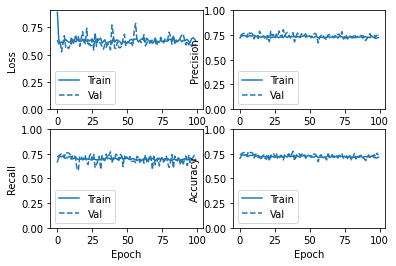

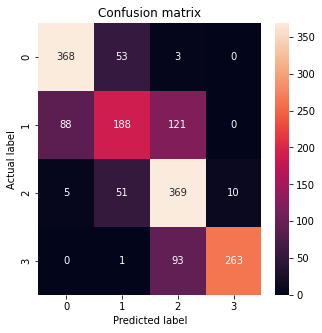

In [163]:
for name, value in zip(modelo.metrics_names, results_evaluate):
  print(name, ': ', value)
print()

plot_metrics(results_fit)

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))

In [132]:
#y_pred = test_predictions_baseline.argmax(axis=1)
#np.argmax(np.asarray(y_test),axis=1)
#print(classification_report(y_pred, np.argmax(np.asarray(y_test),axis=1), digits=4))

In [81]:

#plt.plot(results_fit.history['val_categorical_accuracy'])
#plt.plot(results_fit.history['categorical_accuracy'])

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets